In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Load the dataset

In [2]:
import sys
sys.path.append('/export/home/mirror_pylmnn')

In [3]:
import importlib
import pylmnn.dataset.load_dataset as load_dataset #_dataset_verification
importlib.reload(load_dataset)
data_path = '/export/home/loreal_135_classification'
image_dict, label2id = load_dataset._dataset_verification(data_path)


sample statistics: 
LabelI LabelName                      # samples           
====== ============================== ====================
22     effaclar_foam_gel_400_in       16                  
20     lrp_tin                        19                  
21     effaclar_k_40_out              39                  
10     toleriane_creme_out            44                  
11     lipikar_balm_ap_200_out        44                  
18     rosaliac_ar_intense_out        44                  
7      toleriane_yeux_out             49                  
16     effaclar_k_40_in               58                  
6      cicaplast_balm_40_in           64                  
5      cicaplast_balm_40_out          70                  
9      toleriane_creme_in             72                  
19     effaclar_duo_40_out            76                  
8      toleriane_yeux_in              77                  
4      rosaliac_ar_intense_in         79                  
17     lipikar_balm_ap_200_in       

### keep classes that at least have 50 samples 

In [4]:
importlib.reload(load_dataset)
num_samples = 50
out_dataset = load_dataset._keep_dataset_with_enough_samples(image_dict, num_samples)

sample statistics: 
Label                          # of samples   
============================== ===============
cicaplast_balm_40_in           64             
cicaplast_balm_40_out          70             
effaclar_duo_40_in             151            
effaclar_duo_40_out            76             
effaclar_foam_gel_200_in       100            
effaclar_k_40_in               58             
lipikar_balm_ap_200_in         85             
lipikar_balm_ap_400_in         139            
lipikar_syndet_400_in          112            
lrp_bottle                     2680           
lrp_box                        1193           
lrp_tube                       1861           
price_tag                      8016           
rosaliac_ar_intense_in         79             
toleriane_creme_in             72             
toleriane_yeux_in              77             


### split train/test as half and half

In [5]:
importlib.reload(load_dataset)
ratio = 0.5
data_split = load_dataset._split_dataset_by_ratio(out_dataset, ratio)

sample statistics: 
Label                          Train           Test           
============================== =============== ===============
cicaplast_balm_40_in           32              32             
cicaplast_balm_40_out          35              35             
effaclar_duo_40_in             75              76             
effaclar_duo_40_out            38              38             
effaclar_foam_gel_200_in       50              50             
effaclar_k_40_in               29              29             
lipikar_balm_ap_200_in         42              43             
lipikar_balm_ap_400_in         69              70             
lipikar_syndet_400_in          56              56             
lrp_bottle                     1340            1340           
lrp_box                        596             597            
lrp_tube                       930             931            
price_tag                      4008            4008           
rosaliac_ar_intense_in         39  

### make training set at MOST 50 samples, and test set at MOST 500 samples

In [6]:
train_at_most = 50
test_at_most = 200
data = load_dataset._trim_dataset(data_split, train_at_most, test_at_most)

sample statistics: 
Label                          Train           Test           
============================== =============== ===============
cicaplast_balm_40_in           32              32             
cicaplast_balm_40_out          35              35             
effaclar_duo_40_in             50              76             
effaclar_duo_40_out            38              38             
effaclar_foam_gel_200_in       50              50             
effaclar_k_40_in               29              29             
lipikar_balm_ap_200_in         42              43             
lipikar_balm_ap_400_in         50              70             
lipikar_syndet_400_in          50              56             
lrp_bottle                     50              200            
lrp_box                        50              200            
lrp_tube                       50              200            
price_tag                      50              200            
rosaliac_ar_intense_in         39  

### Visualize the training samples and test samples

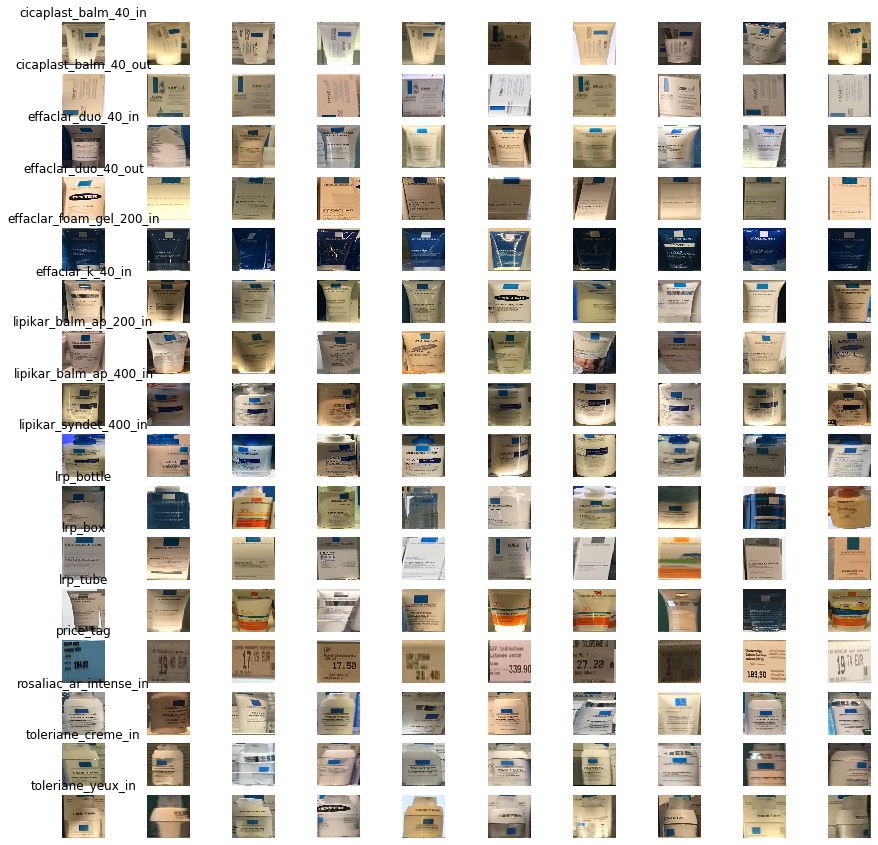

In [7]:
train_set = data['train']
test_set = data['test']

classes = train_set.keys()
num_classes = len(classes)
samples_per_class = 10

plt.figure(figsize=(15, 15))
for y, cls in enumerate(classes):
    idxs = [i for i in range(len(train_set[cls]))]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(num_classes, samples_per_class, plt_idx)
        img = Image.open(train_set[cls][idx])
        img = np.array(img.resize((224, 224)))
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Fine tune resnet101 on the training set

In [8]:
import importlib
import pylmnn.embeddings.create_embeddings as create_embeddings
importlib.reload(create_embeddings)

train_overrides = {'num_cols': 224,
                   'num_rows': 224,
                   'num_epochs': 50,
                   'training_batch_size': 16}

train_cfg = create_embeddings.ClassConfig(train_overrides)

data_labels = create_embeddings.sort_and_dedup(train_set.keys())
print(data_labels)

training_generator = create_embeddings.DataGenerator(dataset=train_set, labels=data_labels,
                                           batch_size=train_cfg.training_batch_size,
                                           dim=(train_cfg.num_rows, train_cfg.num_cols),
                                           num_channels=train_cfg.num_channels, shuffle=True)
validation_generator = create_embeddings.DataGenerator(dataset=test_set, labels=data_labels,
                                             batch_size=train_cfg.training_batch_size,
                                             dim=(train_cfg.num_rows, train_cfg.num_cols),
                                             num_channels=train_cfg.num_channels, shuffle=True)

cls_trainer = create_embeddings.ClassificationTrainer(labels=data_labels, config=train_cfg)

history = cls_trainer.train_resnet101(training_generator=training_generator,
                                    validation_generator=validation_generator)

Using TensorFlow backend.


('cicaplast_balm_40_in', 'cicaplast_balm_40_out', 'effaclar_duo_40_in', 'effaclar_duo_40_out', 'effaclar_foam_gel_200_in', 'effaclar_k_40_in', 'lipikar_balm_ap_200_in', 'lipikar_balm_ap_400_in', 'lipikar_syndet_400_in', 'lrp_bottle', 'lrp_box', 'lrp_tube', 'price_tag', 'rosaliac_ar_intense_in', 'toleriane_creme_in', 'toleriane_yeux_in')
0
0
Training Classification Model...
Epoch 1/50
42/43 [============================>.] - ETA: 0s - loss: 2.8682 - acc: 0.10120
0
43/43 [==============================] - 12s 281ms/step - loss: 2.8643 - acc: 0.1017 - val_loss: 2.9149 - val_acc: 0.0878

Epoch 00001: acc improved from -inf to 0.10174, saving model to resnet101.hdf5
Epoch 2/50
42/43 [============================>.] - ETA: 0s - loss: 2.4821 - acc: 0.20830
0
43/43 [==============================] - 6s 143ms/step - loss: 2.4789 - acc: 0.2093 - val_loss: 2.6048 - val_acc: 0.1540

Epoch 00002: acc improved from 0.10174 to 0.20930, saving model to resnet101.hdf5
Epoch 3/50
41/43 [================

Epoch 28/50
43/43 [==============================] - 6s 132ms/step - loss: 0.5470 - acc: 0.8808 - val_loss: 1.6476 - val_acc: 0.4554

Epoch 00028: acc did not improve from 0.88953
Epoch 29/50
0
42/43 [============================>.] - ETA: 0s - loss: 0.5422 - acc: 0.89730
0
43/43 [==============================] - 6s 135ms/step - loss: 0.5420 - acc: 0.8968 - val_loss: 1.6449 - val_acc: 0.4591

Epoch 00029: acc improved from 0.88953 to 0.89680, saving model to resnet101.hdf5
Epoch 30/50
43/43 [==============================] - 6s 132ms/step - loss: 0.5271 - acc: 0.9070 - val_loss: 1.6610 - val_acc: 0.4568
0

Epoch 00030: acc improved from 0.89680 to 0.90698, saving model to resnet101.hdf5
Epoch 31/50
43/43 [==============================] - 6s 132ms/step - loss: 0.5125 - acc: 0.8953 - val_loss: 1.6241 - val_acc: 0.4673

Epoch 00031: acc did not improve from 0.90698
Epoch 32/50
0
43/43 [==============================] - 6s 133ms/step - loss: 0.4839 - acc: 0.9186 - val_loss: 1.6245 - val_

### Confusion matrix (test set)on Neural Network

In [46]:
importlib.reload(create_embeddings)

prediction_validation_generator = create_embeddings.DataGenerator(dataset=test_set, labels=data_labels,
                                            batch_size=train_cfg.training_batch_size,
                                            dim=(train_cfg.num_rows, train_cfg.num_cols),
                                            num_channels=train_cfg.num_channels, collect_labels=True)

prediction_validation = np.argmax(cls_trainer.predict(data_generator=prediction_validation_generator), axis=1)
label_validation = np.array(prediction_validation_generator.class_indexes)

0
84/84 [==============================] - 6s 67ms/step


(1344,)
(1344,)
[[ 19   2   2   0   0   8   0   0   0   0   1   0   0   0   0   0]
 [  6  26   0   0   0   0   0   0   0   0   1   0   2   0   0   0]
 [  0   0  37   0   0  39   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   4   0  14   0   0   0   0  19   0   0   0   0   0]
 [  0   0  16   1  18   2   9   0   0   1   0   3   0   0   0   0]
 [  0   0  10   0   0  19   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0  14  25   0   0   0   0   2   0   0   0   0]
 [  0   0   3   0   0   9   3  46   0   1   0   1   0   5   2   0]
 [  0   0   6   0   0   6   6  21  12   1   0   0   0   1   3   0]
 [  0   0  33   1   1  29   8  14   0  60   0  10   0  12  32   0]
 [  0   5  13   4   0  50   1   0   0   0 120   4   1   1   1   0]
 [  1   0  32   0   0  98  19   1   0   2   1  43   0   2   1   0]
 [  1   9   0   0   0   0   1   0   0   0   4   0 185   0   0   0]
 [  0   0   2   0   0   7   0   0   0   0   0   0   0  16  15   0]
 [  0   0   0   0   0   6   0   0   0   0   0 

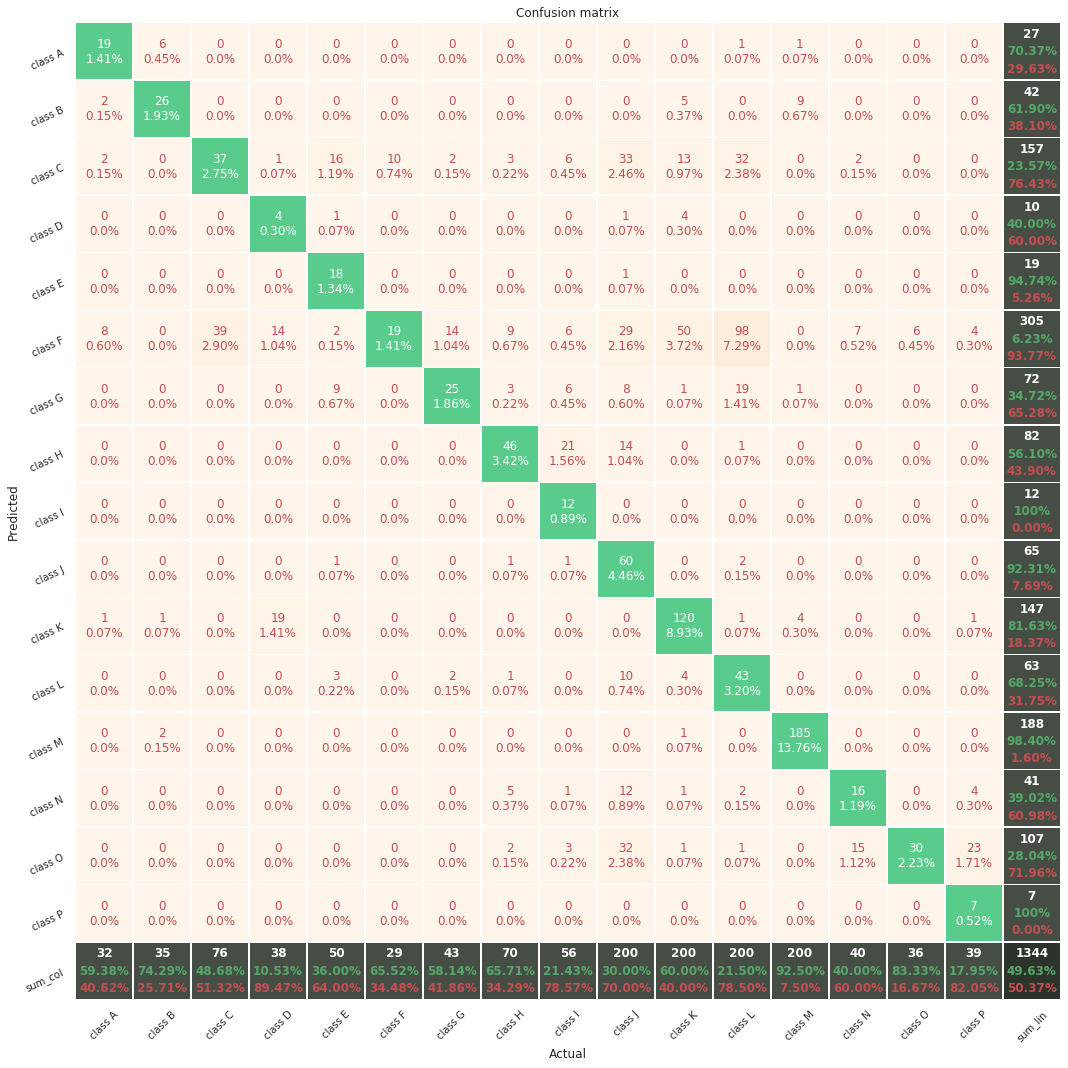

In [47]:
from sklearn.metrics import confusion_matrix
import pylmnn.embeddings.confusion_matrix_pretty_print as confusion_matrix_pretty_print
importlib.reload(confusion_matrix_pretty_print)

print(prediction_validation.shape)
print(label_validation.shape)

cf_matrix = confusion_matrix(label_validation, prediction_validation)

print(cf_matrix)

columns = []
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12;
figsize = [15,15];

confusion_matrix_pretty_print.plot_confusion_matrix_from_data(label_validation, prediction_validation, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

### Training/Test Curve and accuracy

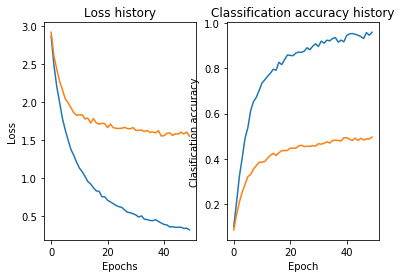

In [9]:
stats = history.history
# Plot the loss function and train / validation accuracies
plt.subplot(1, 2, 1)
plt.plot(stats['loss'], label='train')
plt.plot(stats['val_loss'], label='test')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(stats['acc'], label='train')
plt.plot(stats['val_acc'], label='test')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### CNN feature extraction

In [48]:
importlib.reload(create_embeddings)

feature_training_generator = create_embeddings.DataGenerator(dataset=train_set, labels=data_labels,
                                            batch_size=train_cfg.training_batch_size,
                                            dim=(train_cfg.num_rows, train_cfg.num_cols),
                                            num_channels=train_cfg.num_channels, collect_labels=True)

feature_validation_generator = create_embeddings.DataGenerator(dataset=test_set, labels=data_labels,
                                            batch_size=train_cfg.training_batch_size,
                                            dim=(train_cfg.num_rows, train_cfg.num_cols),
                                            num_channels=train_cfg.num_channels, collect_labels=True)

feature_training = cls_trainer.extract_feature(data_generator=feature_training_generator)
label_training = np.array(feature_training_generator.class_indexes)
np.savez_compressed(os.path.join(data_path, 'em_training.npz'), X=feature_training, y=label_training)

feature_validation = cls_trainer.extract_feature(data_generator=feature_validation_generator)
label_validation = np.array(feature_validation_generator.class_indexes)
np.savez_compressed(os.path.join(data_path, 'em_test.npz'), X=feature_validation, y=label_validation)

print(feature_training.shape)
print(label_training.shape)
print(feature_validation.shape)
print(label_validation.shape)

0
0
84/84 [==============================] - 6s 66ms/step
(688, 2048)
(688,)
(1344, 2048)
(1344,)


### Visualize embedding on CNN feature

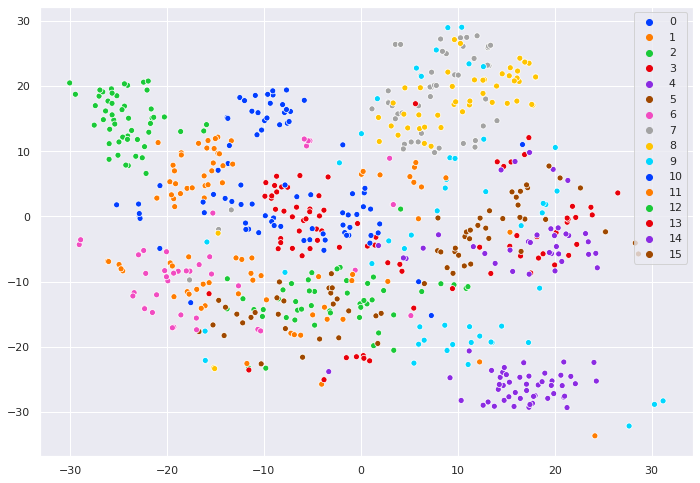

In [49]:
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

palette = sns.color_palette("bright", label_training.max()+1)

tsne = TSNE()
X_embedded_train = tsne.fit_transform(feature_training)

sns.scatterplot(X_embedded_train[:,0], X_embedded_train[:,1], hue=label_training, legend='full', palette=palette)

(1344, 2048)
(1344,)


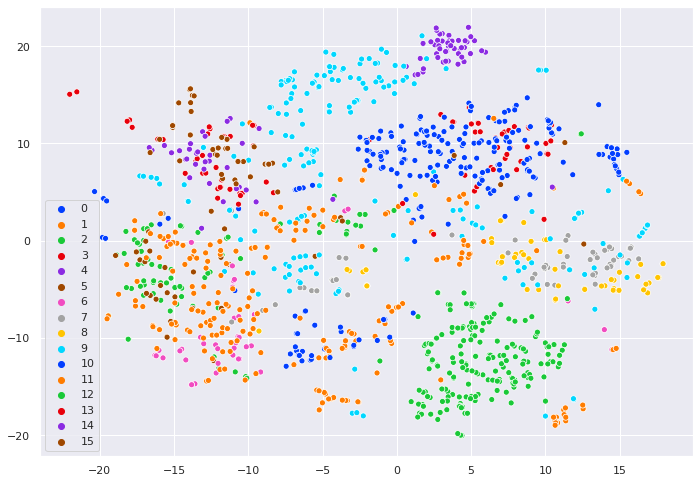

In [50]:
print(feature_validation.shape)
print(label_validation.shape)
palette = sns.color_palette("bright", label_validation.max()+1)

X_embedded_test = tsne.fit_transform(feature_validation)

sns.scatterplot(X_embedded_test[:,0], X_embedded_test[:,1], hue=label_validation, legend='full', palette=palette)


### Nearest Neighbor Raw

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from pylmnn import LargeMarginNearestNeighbor
knn = KNeighborsClassifier(n_neighbors=10)

# Train with no transformation (euclidean metric)
knn.fit(feature_training, label_training)

# Test with euclidean metric
acc = knn.score(feature_validation, label_validation)

print('KNN accuracy on test set: {}'.format(acc))

KNN accuracy on test set: 0.5967261904761905


### Confusion matrix (test set) for Nearest Neighbor Raw

[[ 26   5   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2  33   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  56   0   0  15   3   0   0   0   0   1   0   0   0   0]
 [  0   0   0  35   0   0   0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0  50   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  23   1   0   5   0   0   0   0   0   0   0   0   0   0]
 [  2   0   2   0   0   3  34   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   1  55   8   0   1   0   0   5   0   0]
 [  0   0   0   1   0   0   1  20  34   0   0   0   0   0   0   0]
 [  0   2  11   6  12   8   0  49   7  58   1   7   0  19  11   9]
 [  7  17   4  71   0   0   1   0   0   0  98   0   0   2   0   0]
 [  5   0  60   1   3  20  38  12   4   0   4  47   0   4   2   0]
 [  1   8   0   0   0   0   0   0   0   0   0   0 191   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0  29  10   0]
 [  0   0   1   0   0   0   0   0   0   1   0   0   0  10  24 

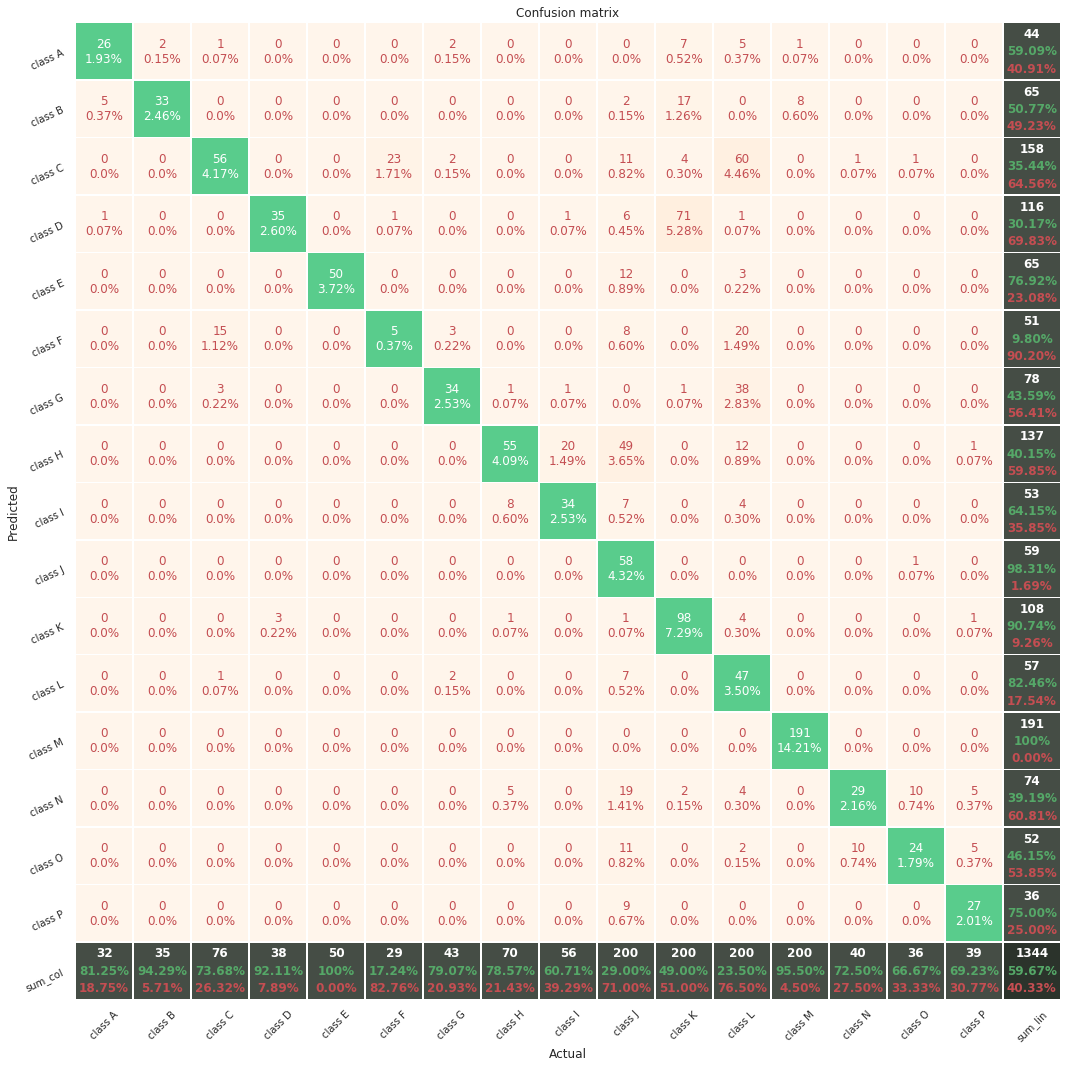

In [52]:
from sklearn.metrics import confusion_matrix
import pylmnn.embeddings.confusion_matrix_pretty_print as confusion_matrix_pretty_print
importlib.reload(confusion_matrix_pretty_print)

prediction_validation = knn.predict(feature_validation)
cf_matrix = confusion_matrix(label_validation, prediction_validation)

print(cf_matrix)

columns = []
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12;
figsize = [15,15];

confusion_matrix_pretty_print.plot_confusion_matrix_from_data(label_validation, prediction_validation, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)



### Large Margin Nearest Neighbor

In [53]:
# LMNN is no longer a classifier but a transformer
lmnn = LargeMarginNearestNeighbor(n_neighbors=10, verbose=1, max_iter=500)
lmnn.fit(feature_training, label_training)

# Train with transformation learned by LMNN
knn.fit(lmnn.transform(feature_training), label_training)

# Test with transformation learned by LMNN
acc = knn.score(lmnn.transform(feature_validation), label_validation)

print('LMNN accuracy on test set: {}'.format(acc))

[LargeMarginNearestNeighbor] Finding principal components...
[LargeMarginNearestNeighbor] Found principal components in  7.22s.
[LargeMarginNearestNeighbor] Finding the target neighbors...
[LargeMarginNearestNeighbor] Found the target neighbors in  0.21s.
[LargeMarginNearestNeighbor] Computing static part of the gradient...
[LargeMarginNearestNeighbor] Computed static part of the gradient in  0.06s.
[LargeMarginNearestNeighbor]
[LargeMarginNearestNeighbor]  Iteration      Objective Value     #Active Triplets    Time(s)
[LargeMarginNearestNeighbor] ---------------------------------------------------------------
[LargeMarginNearestNeighbor]          1         2.243536e+09               92,928       0.95
[LargeMarginNearestNeighbor]          1         7.389273e+08               61,032       0.88
[LargeMarginNearestNeighbor]          2         4.953480e+08               50,964       0.81
[LargeMarginNearestNeighbor]          3         2.226750e+08               35,505       0.91
[LargeMarg

[LargeMarginNearestNeighbor]         72         3.028114e+04                    0       0.88
[LargeMarginNearestNeighbor]         73         2.827182e+04                    0       1.30
[LargeMarginNearestNeighbor]         74         2.296759e+04                    0       1.00
[LargeMarginNearestNeighbor]         75         2.146256e+04                    0       1.29
[LargeMarginNearestNeighbor]         76         1.916501e+04                    0       1.40
[LargeMarginNearestNeighbor]         77         1.664486e+04                    0       1.01
[LargeMarginNearestNeighbor]         78         1.452448e+04                    0       0.99
[LargeMarginNearestNeighbor]         79         1.313211e+04                    0       0.71
[LargeMarginNearestNeighbor]         80         1.183391e+04                    0       0.81
[LargeMarginNearestNeighbor]         81         1.077151e+04                    0       0.89
[LargeMarginNearestNeighbor]         82         9.434023e+03          

[LargeMarginNearestNeighbor]        160         6.961938e+01                    0       0.90
[LargeMarginNearestNeighbor]        161         6.832169e+01                    0       1.08
[LargeMarginNearestNeighbor]        162         6.692097e+01                    0       0.81
[LargeMarginNearestNeighbor]        163         6.539313e+01                    0       0.89
[LargeMarginNearestNeighbor]        164         6.393383e+01                    0       1.36
[LargeMarginNearestNeighbor]        165         6.288907e+01                    0       0.91
[LargeMarginNearestNeighbor]        166         6.170183e+01                    0       0.90
[LargeMarginNearestNeighbor]        167         5.987362e+01                    0       0.84
[LargeMarginNearestNeighbor]        168         5.821389e+01                    0       0.75
[LargeMarginNearestNeighbor]        169         5.688962e+01                    0       0.81
[LargeMarginNearestNeighbor]        170         5.581909e+01          

[LargeMarginNearestNeighbor]        247         7.379499e+00                    0       0.81
[LargeMarginNearestNeighbor]        248         7.254941e+00                    0       0.81
[LargeMarginNearestNeighbor]        249         7.146595e+00                    0       0.80
[LargeMarginNearestNeighbor]        250         7.052360e+00                    0       0.81
[LargeMarginNearestNeighbor]        251         6.873860e+00                    0       1.00
[LargeMarginNearestNeighbor]        252         6.912048e+00                    0       0.81
[LargeMarginNearestNeighbor]        252         6.761727e+00                    0       0.78
[LargeMarginNearestNeighbor]        253         6.626441e+00                    0       0.92
[LargeMarginNearestNeighbor]        254         6.515580e+00                    0       0.91
[LargeMarginNearestNeighbor]        255         6.383451e+00                    0       0.81
[LargeMarginNearestNeighbor]        256         6.255253e+00          

[LargeMarginNearestNeighbor]        331         8.757134e-01                    0       0.80
[LargeMarginNearestNeighbor]        332         8.513555e-01                    0       0.80
[LargeMarginNearestNeighbor]        333         8.333101e-01                    0       0.89
[LargeMarginNearestNeighbor]        334         8.200909e-01                    0       0.80
[LargeMarginNearestNeighbor]        335         8.068119e-01                    0       0.80
[LargeMarginNearestNeighbor]        336         7.937036e-01                    0       0.71
[LargeMarginNearestNeighbor]        337         7.726769e-01                    0       0.90
[LargeMarginNearestNeighbor]        338         7.546720e-01                    0       0.79
[LargeMarginNearestNeighbor]        339         7.393004e-01                    0       0.90
[LargeMarginNearestNeighbor]        340         7.270514e-01                    0       0.90
[LargeMarginNearestNeighbor]        341         7.138814e-01          

[LargeMarginNearestNeighbor]        416         4.372310e-02                    0       0.90
[LargeMarginNearestNeighbor]        417         4.144188e-02                    0       0.90
[LargeMarginNearestNeighbor]        418         3.996108e-02                    0       0.80
[LargeMarginNearestNeighbor]        419         3.846709e-02                    0       0.72
[LargeMarginNearestNeighbor]        420         3.725551e-02                    0       0.81
[LargeMarginNearestNeighbor]        421         3.621695e-02                    0       0.90
[LargeMarginNearestNeighbor]        422         3.465297e-02                    0       0.91
[LargeMarginNearestNeighbor]        423         3.379869e-02                    0       0.81
[LargeMarginNearestNeighbor]        424         3.306153e-02                    0       0.81
[LargeMarginNearestNeighbor]        425         3.136765e-02                    0       0.80
[LargeMarginNearestNeighbor]        426         3.148665e-02          

[LargeMarginNearestNeighbor]        502         1.437204e-03                    0       0.90
[LargeMarginNearestNeighbor] Training took   644.69s.


/export/home/mirror_pylmnn/pylmnn/lmnn.py:322: ConvergenceWarning: [LargeMarginNearestNeighbor] LMNN did not converge: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  ConvergenceWarning)


LMNN accuracy on test set: 0.7782738095238095


### Visualize embedding after LMNN learning

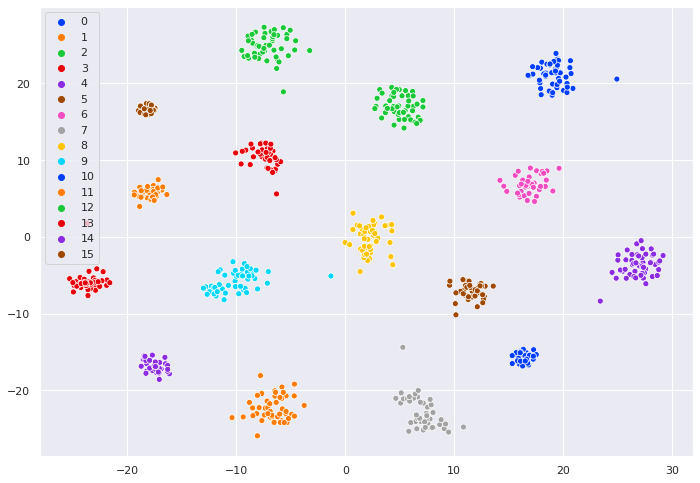

In [54]:
feature_embedded_training = lmnn.transform(feature_training)
#label_training
palette = sns.color_palette("bright", label_training.max()+1)

tsne = TSNE()
X_embedded_train = tsne.fit_transform(feature_embedded_training)

sns.scatterplot(X_embedded_train[:,0], X_embedded_train[:,1], hue=label_training, legend='full', palette=palette)


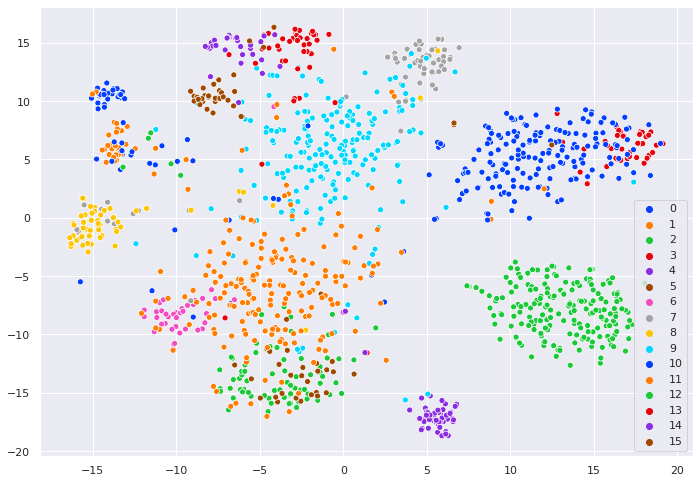

In [55]:
feature_embedded_test = lmnn.transform(feature_validation)
#label_test

tsne = TSNE()
X_embedded_test = tsne.fit_transform(feature_embedded_test)

sns.scatterplot(X_embedded_test[:,0], X_embedded_test[:,1], hue=label_validation, legend='full', palette=palette)

### Confusion matrix (test set) on LMNN

[[ 28   2   0   0   0   0   1   0   0   0   1   0   0   0   0   0]
 [  3  30   0   0   0   0   0   0   0   0   2   0   0   0   0   0]
 [  0   0  54   0   0  14   2   0   0   0   0   4   0   2   0   0]
 [  0   0   0  34   0   0   0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   0  50   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  15   0   0  13   0   0   0   0   0   1   0   0   0   0]
 [  1   0   1   0   0   0  39   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   2  56  10   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   8  46   0   0   0   0   1   0   0]
 [  0   0   4   1   2   2   3  10   2 146   1  14   0   9   1   5]
 [  1  13   0  38   0   0   2   0   0   2 140   4   0   0   0   0]
 [  1   0  26   0   0   3  29   3   0   4   4 122   0   8   0   0]
 [  1   6   0   0   0   0   0   0   0   0   0   1 192   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   1   0  36   1   0]
 [  0   0   2   0   0   1   0   0   0   0   0   0   0   3  28 

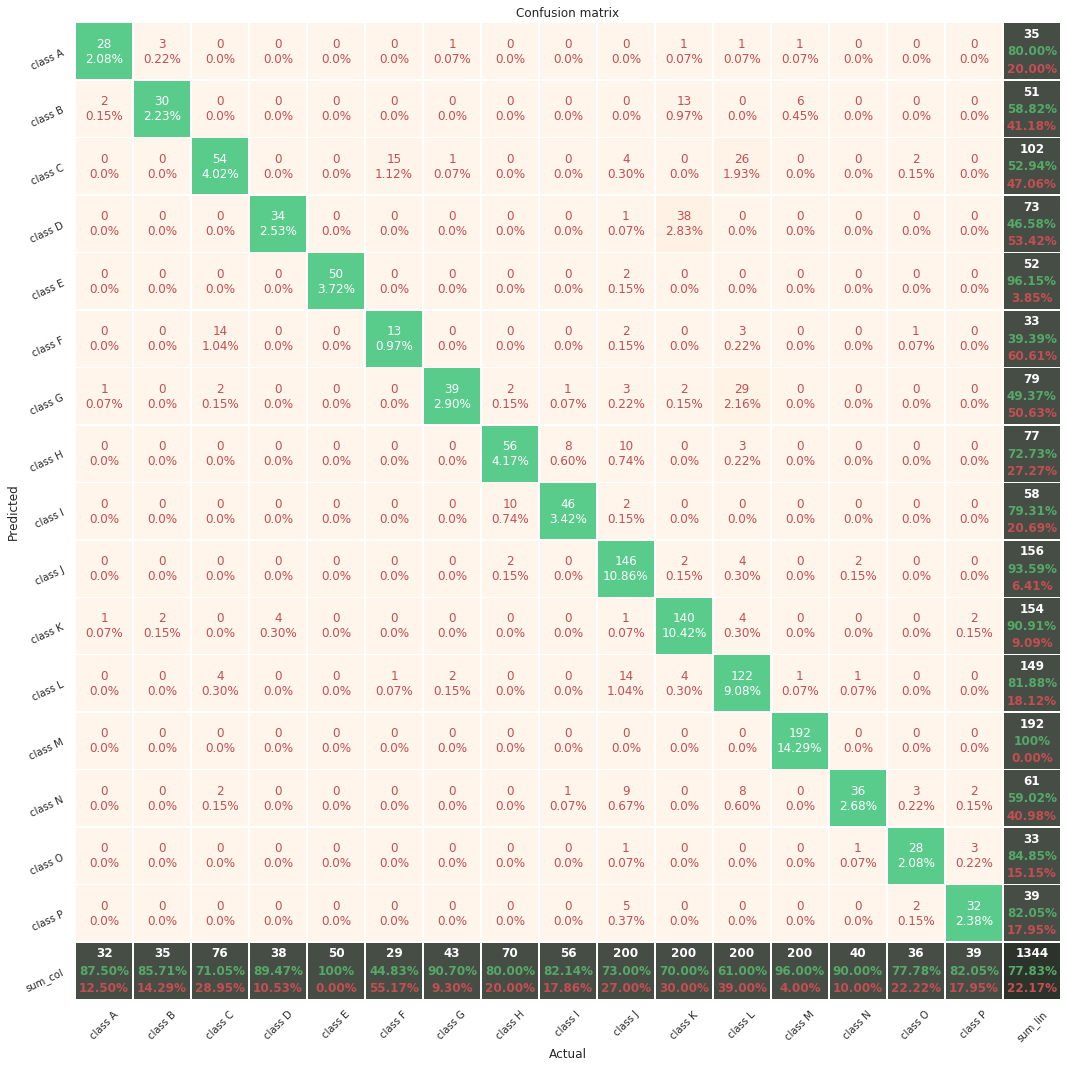

In [56]:
from sklearn.metrics import confusion_matrix
import pylmnn.embeddings.confusion_matrix_pretty_print as confusion_matrix_pretty_print
importlib.reload(confusion_matrix_pretty_print)

prediction_validation = knn.predict(feature_embedded_test)
cf_matrix = confusion_matrix(label_validation, prediction_validation)

print(cf_matrix)

columns = []
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12;
figsize = [15,15];

confusion_matrix_pretty_print.plot_confusion_matrix_from_data(label_validation, prediction_validation, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)